In [1]:
import time
import numpy as np
from random import random as rand
from math import floor
from numba import cuda
import matplotlib.pyplot as plt

from osnps.base import KnapsackProblem
from osnps.concrete import SerialOSNPS, ParallelOSNPS

In [2]:
def normalize(arr):
    max_val = float(np.max(arr))
    return [i / max_val for i in arr]

# OSNPS Experiments

## 1. Runtime vs Generations

In [3]:
runs = [
    250,
    500,
    750,
    1000,
    1250,
    1500
]

H = 64
m = 1024

threads_per_block = (16,64)
blocks_per_grid = (16,16)

reps = 7

In [4]:
kp = KnapsackProblem(m)
ffxn = kp.fitness()

In [5]:
model_cpu = SerialOSNPS(H, m, fitness=ffxn)

model_gpu = ParallelOSNPS(H, m, fitness=ffxn)
model_gpu.set_GPU_params(threads_per_block, blocks_per_grid)

## CPU (Unoptimized)

In [6]:
%timeit _, max_fs, runtime_fs = model_cpu.run_unopt(runs[0])

49.5 s ± 1.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit _, max_fs, runtime_fs = model_cpu.run_unopt(runs[1])

1min 40s ± 1.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit _, max_fs, runtime_fs = model_cpu.run_unopt(runs[2])

2min 31s ± 2.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit _, max_fs, runtime_fs = model_cpu.run_unopt(runs[3])

3min 22s ± 684 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit _, max_fs, runtime_fs = model_cpu.run_unopt(runs[4])

5min 34s ± 3min 26s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit _, max_fs, runtime_fs = model_cpu.run_unopt(runs[5])

5min 3s ± 689 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## CPU

In [6]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[0])

737 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[1])

1.4 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[2])

2.07 s ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[3])

2.74 s ± 6.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[4])

3.43 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[5])

4.1 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## GPU

In [12]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[0])

1.75 s ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[1])

3.46 s ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[2])

5.19 s ± 7.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[3])

7.07 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[4])

8.7 s ± 72.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[5])

10.4 s ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2. Convergence of solutions

In [12]:
runs = 1000

H = 64
m = 1024

threads_per_block = (16,64)
blocks_per_grid = (16,16)

reps = 7

In [13]:
kp = KnapsackProblem(m)
ffxn = kp.fitness()

In [14]:
model_cpu = SerialOSNPS(H, m, fitness=ffxn)

model_gpu = ParallelOSNPS(H, m, fitness=ffxn)
model_gpu.set_GPU_params(threads_per_block, blocks_per_grid)

In [15]:
cpu_runs = []
cpu_unopt_runs = []
gpu_runs = []

for i in range(7):
    _, max_fs, _ = model_cpu.run(runs)
    cpu_runs.append(max_fs)
    print("CPU, run {}".format(i))
    
    _, max_fsu, _ = model_cpu.run(runs)
    cpu_unopt_runs.append(max_fsu)
    print("CPU (unopt), run {}".format(i))
    
    _, max_fp, _ = model_gpu.run(runs)
    gpu_runs.append(max_fp)
    print("GPU, run {}".format(i))

CPU, run 0
CPU (unopt), run 0
GPU, run 0
CPU, run 1
CPU (unopt), run 1
GPU, run 1
CPU, run 2
CPU (unopt), run 2
GPU, run 2
CPU, run 3
CPU (unopt), run 3
GPU, run 3
CPU, run 4
CPU (unopt), run 4
GPU, run 4
CPU, run 5
CPU (unopt), run 5
GPU, run 5
CPU, run 6
CPU (unopt), run 6
GPU, run 6


In [16]:
for i in range(reps):
    cpu_runs[i] = normalize(cpu_runs[i])
    cpu_unopt_runs[i] = normalize(cpu_unopt_runs[i])
    gpu_runs[i] = normalize(gpu_runs[i])

In [17]:
cpu_fitnessruns = np.array(cpu_runs)
cpu_unopt_fitnessruns = np.array(cpu_unopt_runs)
gpu_fitnessruns = np.array(gpu_runs)

np.save('cpu_fitnessruns', cpu_fitnessruns)
np.save('cpu_unopt_fitnessruns', cpu_unopt_fitnessruns)
np.save('gpu_fitnessruns', gpu_fitnessruns)

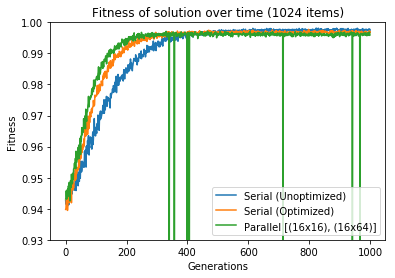

In [28]:
plt.plot(np.arange(runs+1), np.mean(cpu_unopt_fitnessruns, axis=0))
plt.plot(np.arange(runs+1), np.mean(cpu_fitnessruns, axis=0))
plt.plot(np.arange(runs+1), np.mean(gpu_fitnessruns, axis=0))

plt.legend(['Serial (Unoptimized)', 'Serial (Optimized)', 'Parallel [(16x16), (16x64)]'], loc='lower right')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness of solution over time (1024 items)')

ax = plt.gca()
ax.set_ylim([0.93,1.00]) # Skip outlier

plt.show()

## 3. Runtime vs Problem Size

In [19]:
runs = 1000
H = 64
ms = [
    128,
    256,
    512,
    1024,
    2048,
]

threads_per_block = (8,128)
blocks_per_grid = (8,32)

reps = 7

In [20]:
ffxns = [KnapsackProblem(m).fitness() for m in ms]

In [21]:
models_cpu = [SerialOSNPS(H, ms[i], fitness=ffxns[i]) for i in range(len(ms))]
models_gpu = [ParallelOSNPS(H, ms[i], fitness=ffxns[i]) for i in range(len(ms))]

for gpu in models_gpu:
    gpu.set_GPU_params(threads_per_block, blocks_per_grid)

### CPU (Unoptimized)

In [22]:
%timeit _, max_fs, runtime_fs = models_cpu[0].run_unopt(runs)

30.7 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit _, max_fs, runtime_fs = models_cpu[1].run_unopt(runs)

1min ± 498 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit _, max_fs, runtime_fs = models_cpu[2].run_unopt(runs)

2min 1s ± 783 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit _, max_fs, runtime_fs = models_cpu[3].run_unopt(runs)

4min 3s ± 1.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit _, max_fs, runtime_fs = models_cpu[4].run_unopt(runs)

8min 8s ± 1.84 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### CPU

In [28]:
%timeit _, max_fs, runtime_fs = models_cpu[0].run(runs)

1.37 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit _, max_fs, runtime_fs = models_cpu[1].run(runs)

1.59 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit _, max_fs, runtime_fs = models_cpu[2].run(runs)

2.06 s ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit _, max_fs, runtime_fs = models_cpu[3].run(runs)

2.89 s ± 36.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit _, max_fs, runtime_fs = models_cpu[4].run(runs)

4.58 s ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### GPU

In [33]:
%timeit _, max_fs, runtime_fs = models_gpu[0].run(runs)

2.47 s ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit _, max_fs, runtime_fs = models_gpu[1].run(runs)

2.96 s ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%timeit _, max_fs, runtime_fs = models_gpu[2].run(runs)

4.6 s ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%timeit _, max_fs, runtime_fs = models_gpu[3].run(runs)

7.01 s ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit _, max_fs, runtime_fs = models_gpu[4].run(runs)

12.3 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## GPU Stress-testing